In [1]:
from lxml import etree
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import cv2
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


# Summary

## Segmentation
In this section, you will have to reformulate your CNN for image classification into a CNN for pixel-wise classification. As such, each pixel gets a label of belonging to a certain object or not and the result is a segmented image. Optionally, for this purpose you can group all available objects in an image into one single foreground class and do binary image segmentation. <br>

You main task is simple: build a segmentation CNN of your choice (with the loss function you applied before) and visualize the training and validation learning curves. As you will notice, now the loss or other standard metrics like accuracy are less meaningful. Find better metrics and make sure to visualize your segmented images in a nice way.


In [2]:
# parameters that you should set before running this script
voc_root_folder = r'''C:\Users\Triguna\Documents\Thesis\ReferenceCode\Computer Vision\VOCdevkit\\'''  # please replace with the location on your laptop where you unpacked the tarball
image_size = 128    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)
img_rows, img_cols = image_size, image_size
n_channels = 3

In [3]:
# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Segmentation/")
classes_files = os.listdir(classes_folder)
seg_train_files = [os.path.join(classes_folder, c_f) for c_f in classes_files if 'train.txt' in c_f]
seg_val_files = [os.path.join(classes_folder, c_f) for c_f in classes_files if 'val.txt' in c_f]

In [4]:
ann_files = [os.path.join(annotation_folder, a_f) for a_f in annotation_files]
columns = ['Filename','Fileid','Width','Height','Object_Name','Pose','Xmin','Ymin','Xmax','Ymax']
annotations_df = pd.DataFrame(columns=columns) #Each row corresponds to a segmented image
for ann_file in ann_files:
    tree = ET.parse(ann_file)
    root = tree.getroot()
    xmin,ymin,xmax,ymax = 0,0,0,0
    for elem in root:
        if elem.tag == 'filename':
            filename = elem.text
            fileid = filename[:10]
        if elem.tag == 'size':
            for e in elem:
                if e.tag == 'width':
                    width = e.text
                if e.tag == 'height':
                    height = e.text
        if elem.tag == 'object':
            for e in elem:
                if e.tag == 'name':
                    name = e.text
                if e.tag == 'pose':
                    pose = e.text
                if e.tag == 'bndbox':
                    for b in e:
                        if b.tag == 'xmin':
                            xmin = b.text
                        if b.tag == 'ymin':
                            ymin = b.text
                        if b.tag == 'xmax':
                            xmax = b.text
                        if b.tag == 'ymax':
                            ymax = b.text
                    df = pd.DataFrame([[filename,fileid,width,height,name,pose,xmin,ymin,xmax,ymax]],columns = columns)
                    annotations_df = annotations_df.append(df)

annotations_df.reset_index(drop=True,inplace=True)
annotations_df.to_csv('annotations_df.csv')
print(annotations_df.shape)
annotations_df.head()

(21544, 10)


,Filename,Fileid,Width,Height,Object_Name,Pose,Xmin,Ymin,Xmax,Ymax
0,2007_000027.jpg,2007_00002,486,500,person,Unspecified,174,101,349,351
1,2007_000032.jpg,2007_00003,500,281,aeroplane,Frontal,104,78,375,183
2,2007_000032.jpg,2007_00003,500,281,aeroplane,Left,133,88,197,123
3,2007_000032.jpg,2007_00003,500,281,person,Rear,195,180,213,229
4,2007_000032.jpg,2007_00003,500,281,person,Rear,26,189,44,238


## Get the data for training and validation.

Group all the objects into one in order to do binary image segmentation.

### Keep the training images as it is
#### But divide the validation set into two equal halves: one for validation & other for testing

In [5]:
#Training
image_path = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
segmentation_classes_path = os.path.join(voc_root_folder, "VOC2009/SegmentationClass/")

file = open(seg_train_files[0], 'r') 
seg_train_filenames = file.read().splitlines()

seg_train_images = []
segmented_images = []
grayscale_images = []
binary_segmented_images = []
for img_name in seg_train_filenames:
    img = io.imread(image_path+img_name+'.jpg')
    img = cv2.resize(img, dsize=(img_rows,img_cols), interpolation=cv2.INTER_CUBIC) #Resize the images
    seg_train_images.append(img)
    
    seg_img = io.imread(segmentation_classes_path+img_name+'.png')
    seg_img = cv2.resize(seg_img, dsize=(img_rows,img_cols), interpolation=cv2.INTER_CUBIC) #Resize the segments
    segmented_images.append(seg_img)
    
    #Gray scale image of the original image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grayscale_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2BGR)
    grayscale_images.append(grayscale_img)
    
    #Group the objects into one intensity and do binary image segmentation
    binary_seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2GRAY)
    binary_seg_img = 255*((binary_seg_img>0).astype('uint8'))
    binary_seg_img = cv2.cvtColor(binary_seg_img, cv2.COLOR_GRAY2BGR)
    binary_segmented_images.append(binary_seg_img)

segmentation_class_train_df = pd.DataFrame()
segmentation_class_train_df['Image_Name'] = seg_train_filenames
segmentation_class_train_df['Image_Array'] = seg_train_images
segmentation_class_train_df['Segmented_Image_Array'] = segmented_images
segmentation_class_train_df['Grayscale_Image_Array'] = grayscale_images
segmentation_class_train_df['Binary_Segmented_Image_Array'] = binary_segmented_images

segmentation_class_train_df = segmentation_class_train_df.sample(frac=1) #Shuffle the rows so different classes are mixed
segmentation_class_train_df.reset_index(drop=True,inplace=True)
print('Saving training images')
#segmentation_class_train_df.to_pickle('X_Train_Segmentation_'+str(img_rows)+'.pkl') #Save the dataframe to pickle
print('Saved ' + str(segmentation_class_train_df.shape[0]) + ' images')

print(segmentation_class_train_df.shape)
segmentation_class_train_df.head()

Saving training images
Saved 749 images
(749, 5)


,Image_Name,Image_Array,Segmented_Image_Array,Grayscale_Image_Array,Binary_Segmented_Image_Array
0,2007_005124,"[[[112, 86, 85], [113, 84, 80], [108, 83, 80],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[89, 89, 89], [86, 86, 86], [85, 85, 85], [8...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,2009_002897,"[[[171, 177, 177], [172, 178, 178], [171, 177,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[176, 176, 176], [177, 177, 177], [176, 176,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,2008_003196,"[[[236, 246, 253], [238, 247, 255], [238, 247,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[247, 247, 247], [248, 248, 248], [248, 248,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,2009_003961,"[[[7, 7, 7], [5, 5, 5], [5, 5, 5], [7, 7, 7], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[7, 7, 7], [5, 5, 5], [5, 5, 5], [7, 7, 7], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,2008_005926,"[[[95, 86, 64], [102, 86, 63], [103, 88, 70], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[80, 80, 80], [81, 81, 81], [84, 84, 84], [8...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


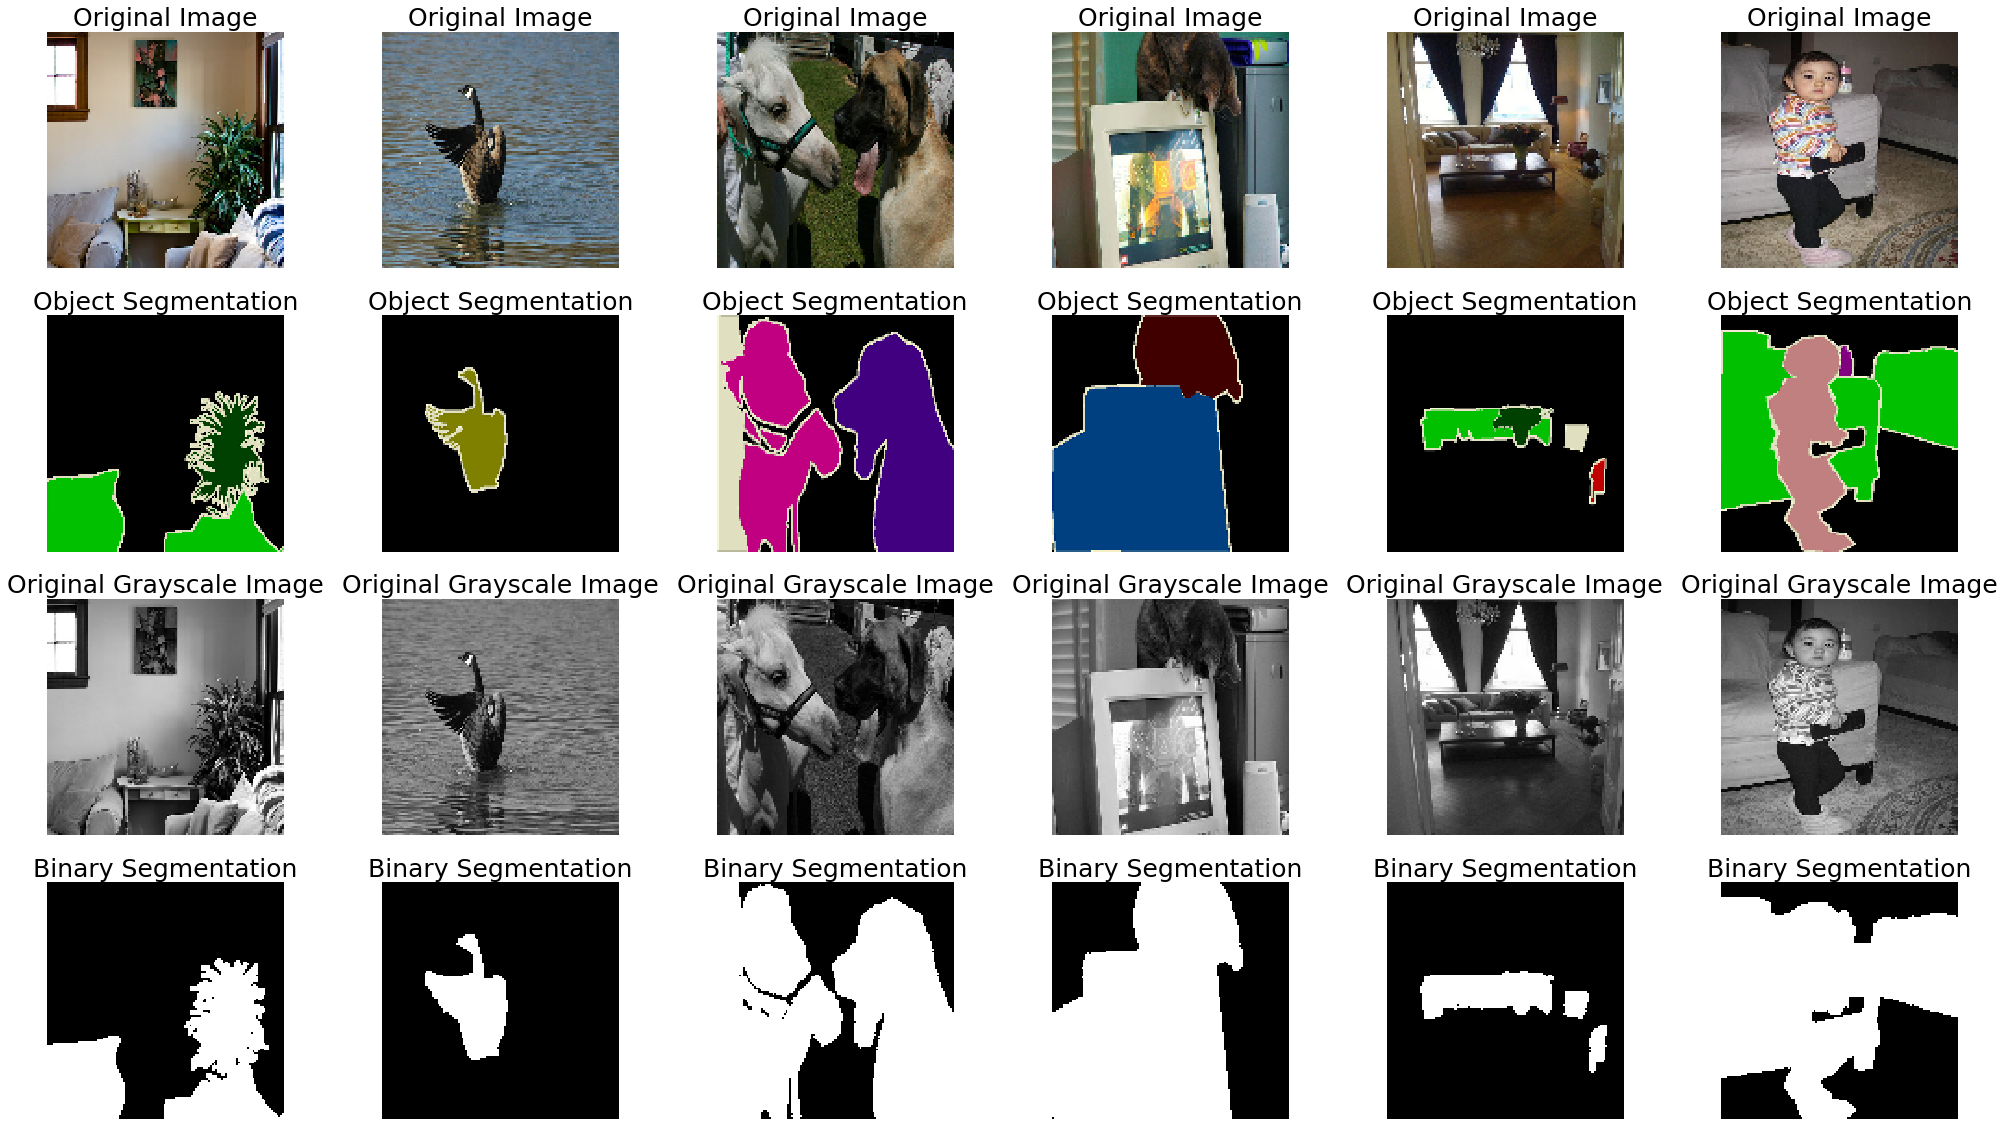

In [6]:
random_indices = [random.randint(0, segmentation_class_train_df.shape[0]) for i in range(6)] 
fig = plt.figure(figsize=(35,20))
ax = fig.subplots(4, 6)
i=0
for index in random_indices:
    actual = segmentation_class_train_df.iloc[index]['Image_Array']
    segmented = segmentation_class_train_df.iloc[index]['Segmented_Image_Array']
    actual_grayscale = segmentation_class_train_df.iloc[index]['Grayscale_Image_Array']
    binary_segmented = segmentation_class_train_df.iloc[index]['Binary_Segmented_Image_Array']
    ax[0,i].imshow(actual)
    ax[0,i].axis('off')
    ax[0,i].set_title('Original Image', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[1,i].imshow(segmented)
    ax[1,i].axis('off')
    ax[1,i].set_title('Object Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[2,i].imshow(actual_grayscale)
    ax[2,i].axis('off')
    ax[2,i].set_title('Original Grayscale Image', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[3,i].imshow(binary_segmented, cmap='gray')
    ax[3,i].axis('off')
    ax[3,i].set_title('Binary Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    i = i+1
plt.show()

In [7]:
#Validation images
file = open(seg_val_files[0], 'r') 
temp_filenames = file.read().splitlines()
seg_val_filenames = [f_n for f_n in temp_filenames if f_n not in seg_train_filenames]

seg_val_images = []
segmented_images = []
grayscale_images = []
binary_segmented_images = []
for img_name in seg_val_filenames:
    img = io.imread(image_path+img_name+'.jpg')
    img = cv2.resize(img, dsize=(img_rows,img_cols), interpolation=cv2.INTER_CUBIC) #Resize the images
    seg_val_images.append(img)
    
    seg_img = io.imread(segmentation_classes_path+img_name+'.png')
    seg_img = cv2.resize(seg_img, dsize=(img_rows,img_cols), interpolation=cv2.INTER_CUBIC) #Resize the segments
    segmented_images.append(seg_img)
    
    #Gray scale image of the original image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grayscale_img = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2BGR)
    grayscale_images.append(grayscale_img)
    
    #Group the objects into one intensity and do binary image segmentation    
    binary_seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2GRAY)
    binary_seg_img = 255*((binary_seg_img>0).astype('uint8'))
    binary_seg_img = cv2.cvtColor(binary_seg_img, cv2.COLOR_GRAY2BGR)
    binary_segmented_images.append(binary_seg_img)
    
segmentation_class_val_df = pd.DataFrame()
segmentation_class_val_df['Image_Name'] = seg_val_filenames
segmentation_class_val_df['Image_Array'] = seg_val_images
segmentation_class_val_df['Segmented_Image_Array'] = segmented_images
segmentation_class_val_df['Grayscale_Image_Array'] = grayscale_images
segmentation_class_val_df['Binary_Segmented_Image_Array'] = binary_segmented_images

segmentation_class_val_df = segmentation_class_val_df.sample(frac=1) #Shuffle the rows so different classes are mixed
segmentation_class_val_df.reset_index(drop=True,inplace=True)

#Divide the validation data into two equal halves - one for validation and other for test
segmentation_class_test_df = segmentation_class_val_df[np.int(segmentation_class_val_df.shape[0]/2):]  #Contains the test image (375 segmented images)
segmentation_class_test_df.reset_index(drop=True,inplace=True)
print(segmentation_class_test_df.shape)

segmentation_class_val_df = segmentation_class_val_df[:np.int(segmentation_class_val_df.shape[0]/2)]   #Contains the validation image (375 segmented images)
segmentation_class_val_df.reset_index(drop=True,inplace=True)
print(segmentation_class_val_df.shape)

print('Saving validation images')
#segmentation_class_val_df.to_pickle('X_Val_Segmentation_'+str(img_rows)+'.pkl') #Save the dataframe to pickle
print('Saved ' + str(segmentation_class_val_df.shape[0]) + ' images')
print(segmentation_class_val_df.shape)
segmentation_class_val_df.head()

(375, 5)
(375, 5)
Saving validation images
Saved 375 images
(375, 5)


,Image_Name,Image_Array,Segmented_Image_Array,Grayscale_Image_Array,Binary_Segmented_Image_Array
0,2009_003005,"[[[183, 196, 205], [183, 196, 205], [184, 196,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[197, 197, 197], [197, 197, 197], [197, 197,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,2007_005074,"[[[30, 30, 30], [29, 29, 29], [27, 27, 27], [4...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[30, 30, 30], [29, 29, 29], [27, 27, 27], [4...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,2007_002643,"[[[65, 65, 41], [88, 84, 59], [74, 70, 51], [2...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[58, 58, 58], [77, 77, 77], [65, 65, 65], [3...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,2008_007596,"[[[17, 17, 17], [28, 28, 28], [37, 37, 37], [1...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[17, 17, 17], [28, 28, 28], [37, 37, 37], [1...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,2007_003530,"[[[4, 4, 4], [3, 4, 6], [8, 9, 11], [9, 9, 9],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[4, 4, 4], [4, 4, 4], [9, 9, 9], [9, 9, 9], ...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [8]:
#Testing images
print('Saving test images')
#segmentation_class_test_df.to_pickle('X_Test_Segmentation_'+str(img_rows)+'.pkl') #Save the dataframe to pickle
print('Saved ' + str(segmentation_class_test_df.shape[0]) + ' images')
print(segmentation_class_test_df.shape)
segmentation_class_test_df.head()

Saving test images
Saved 375 images
(375, 5)


,Image_Name,Image_Array,Segmented_Image_Array,Grayscale_Image_Array,Binary_Segmented_Image_Array
0,2009_000845,"[[[121, 156, 243], [121, 155, 242], [120, 154,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[178, 178, 178], [177, 177, 177], [176, 176,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,2009_000387,"[[[217, 221, 230], [217, 221, 230], [219, 223,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[223, 223, 223], [223, 223, 223], [225, 225,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,2009_002164,"[[[179, 169, 177], [166, 156, 164], [171, 161,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[173, 173, 173], [160, 160, 160], [165, 165,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,2009_002295,"[[[20, 23, 7], [27, 39, 15], [41, 57, 28], [40...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[18, 18, 18], [30, 30, 30], [47, 47, 47], [4...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,2009_005089,"[[[81, 127, 194], [75, 131, 195], [79, 129, 19...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[[142, 142, 142], [144, 144, 144], [142, 142,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


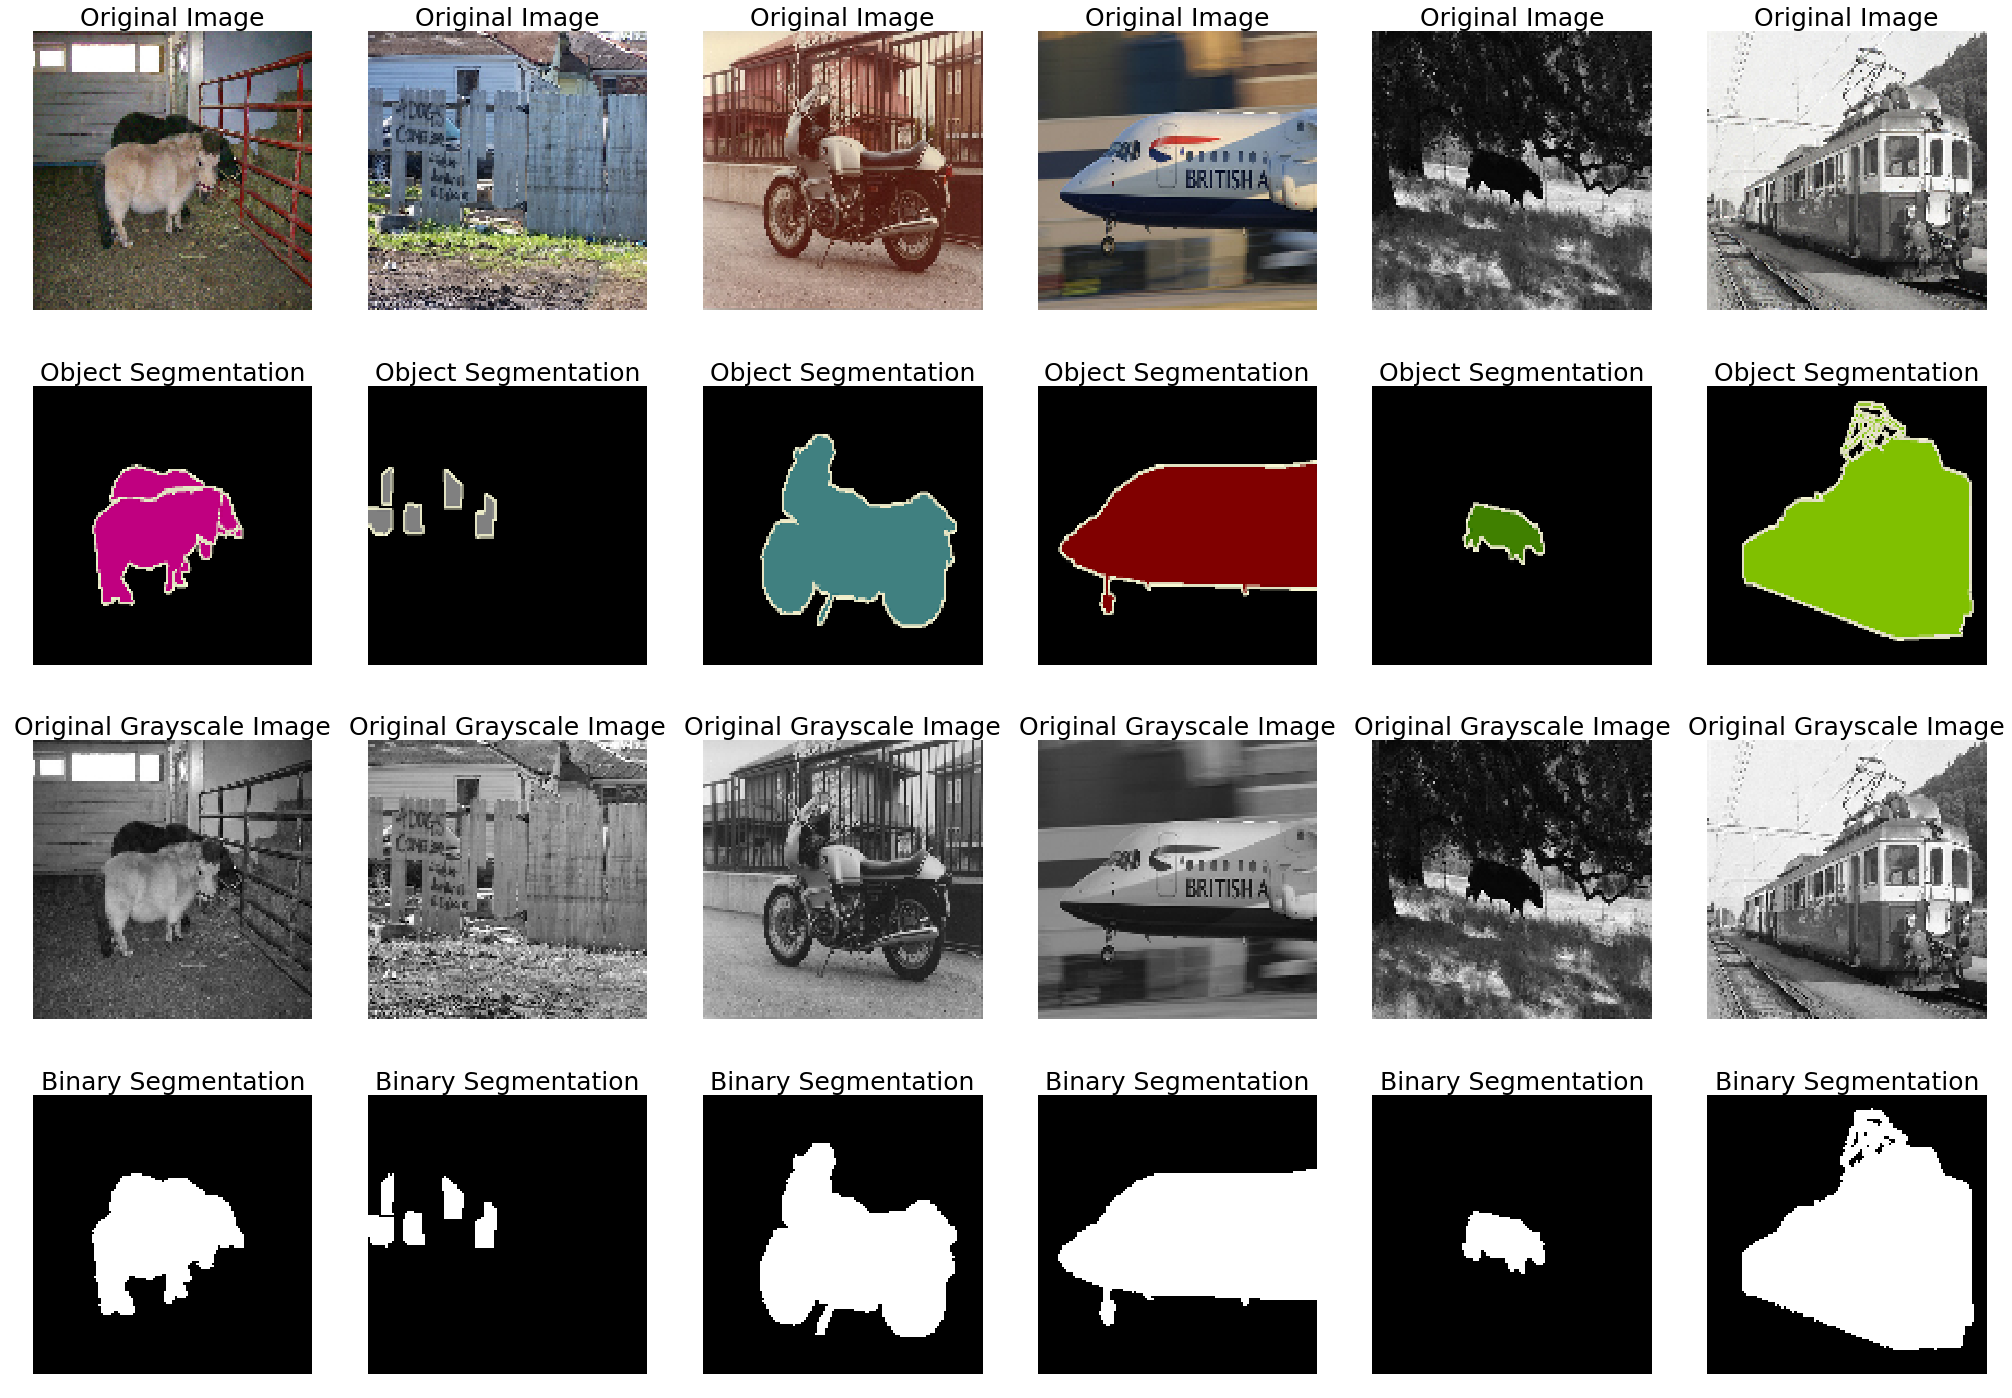

In [9]:
random_indices = [random.randint(0, segmentation_class_val_df.shape[0]) for i in range(6)] 
fig = plt.figure(figsize=(35,25))
ax = fig.subplots(4, 6)
i=0
for index in random_indices:
    actual = segmentation_class_val_df.iloc[index]['Image_Array']
    segmented = segmentation_class_val_df.iloc[index]['Segmented_Image_Array']
    actual_grayscale = segmentation_class_val_df.iloc[index]['Grayscale_Image_Array']
    binary_segmented = segmentation_class_val_df.iloc[index]['Binary_Segmented_Image_Array']
    ax[0,i].imshow(actual)
    ax[0,i].axis('off')
    ax[0,i].set_title('Original Image', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[1,i].imshow(segmented)
    ax[1,i].axis('off')
    ax[1,i].set_title('Object Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[2,i].imshow(actual_grayscale)
    ax[2,i].axis('off')
    ax[2,i].set_title('Original Grayscale Image', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[3,i].imshow(binary_segmented, cmap='gray')
    ax[3,i].axis('off')
    ax[3,i].set_title('Binary Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    i = i+1
plt.show()

In [10]:
segmentation_class_train_df = pd.read_pickle('X_Train_Segmentation_128.pkl')
segmentation_class_val_df = pd.read_pickle('X_Val_Segmentation_128.pkl')
segmentation_class_test_df = pd.read_pickle('X_Test_Segmentation_128.pkl')

x_train = np.array(segmentation_class_train_df['Image_Array'].values.tolist())
print(x_train.shape)
x_train_grayscale = np.array(segmentation_class_train_df['Grayscale_Image_Array'].values.tolist())
print(x_train_grayscale.shape)
y_train = np.array(segmentation_class_train_df['Binary_Segmented_Image_Array'].values.tolist())
print(y_train.shape)

x_val = np.array(segmentation_class_val_df['Image_Array'].values.tolist())
print(x_val.shape)
x_val_grayscale = np.array(segmentation_class_val_df['Grayscale_Image_Array'].values.tolist())
print(x_val_grayscale.shape)
y_val = np.array(segmentation_class_val_df['Binary_Segmented_Image_Array'].values.tolist())
print(y_val.shape)

x_test = np.array(segmentation_class_test_df['Image_Array'].values.tolist())
print(x_test.shape)
x_test_grayscale = np.array(segmentation_class_test_df['Grayscale_Image_Array'].values.tolist())
print(x_test_grayscale.shape)
y_test = np.array(segmentation_class_test_df['Binary_Segmented_Image_Array'].values.tolist())
print(y_test.shape)

(749, 128, 128, 3)
(749, 128, 128, 3)
(749, 128, 128, 3)
(375, 128, 128, 3)
(375, 128, 128, 3)
(375, 128, 128, 3)
(375, 128, 128, 3)
(375, 128, 128, 3)
(375, 128, 128, 3)


## Auto-encoder like structure for binary segmentation

The training is performed using the convolutional auto-encoder with input being the original image and output being the binary segmented image like shown in the figure below:
<img src='binary_segmentation_training.png'>

In [11]:
#Metrics for Keras
from keras import backend as K
from keras.losses import binary_crossentropy
  
#Dice Score Metric
def dice_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
  
#Dice Score Loss
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

#Jaccard Score Metric
def jaccard_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)    

### Input is the color image of shape (img_rows,img_cols,3) and output is a segmented binary image

In [12]:
#CONV Auto-encoder like structure for pixelwise classification
n_epochs = 15
n_batches = 256
#Run on Google Colab. Takes time
'''
input_img = Input(shape=(img_rows, img_cols, n_channels))
layer = Conv2D(64, (3, 3), padding='same')(input_img)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2, 2), padding='same')(layer)
layer = Conv2D(32, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2, 2), padding='same')(layer)
layer = Conv2D(16, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
encoded = MaxPooling2D((2, 2), padding='same', name='code')(layer)

layer = Conv2D(16, (3, 3), padding='same')(encoded)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(32, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(64, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(3, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
decoded = Activation('sigmoid')(layer)

binary_segmenter_model = Model(input_img, decoded)
print(binary_segmenter_model.summary())
binary_segmenter_model.compile(optimizer='adam', loss=[dice_coef]) #Try with other optimizers like 'adadelta'
#binary_crossentropy loss function provided a better iou & dice score than cosine_proximity or logcosh
#With default metrics, I got a better performance

history = binary_segmenter_model.fit(x_train, y_train,epochs=n_epochs,batch_size=n_batches,verbose=1,
                                     validation_data=(x_val, y_val),shuffle=True)

# serialize model to JSON
model_json = binary_segmenter_model.to_json()
with open("binary_segmenter_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
binary_segmenter_model.save_weights("binary_segmenter_model.h5")
with open('binary_segmenter_model_history_dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print("Saved model & history to disk")
'''

'\ninput_img = Input(shape=(img_rows, img_cols, n_channels))\nlayer = Conv2D(64, (3, 3), padding=\'same\')(input_img)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = MaxPooling2D((2, 2), padding=\'same\')(layer)\nlayer = Conv2D(32, (3, 3), padding=\'same\')(layer)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = MaxPooling2D((2, 2), padding=\'same\')(layer)\nlayer = Conv2D(16, (3, 3), padding=\'same\')(layer)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nencoded = MaxPooling2D((2, 2), padding=\'same\', name=\'code\')(layer)\n\nlayer = Conv2D(16, (3, 3), padding=\'same\')(encoded)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = UpSampling2D((2, 2))(layer)\nlayer = Conv2D(32, (3, 3), padding=\'same\')(layer)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = UpSampling2D((2, 2))(layer)\nlayer = Conv2D(64, (3, 3), padding=\'sa

In [13]:
# load json and create model
json_file = open('binary_segmenter_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
binary_segmenter_model = model_from_json(loaded_model_json)
# load weights into new model
binary_segmenter_model.load_weights("binary_segmenter_model.h5")
print("Loaded model from disk")
binary_segmenter_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_15 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        18464     
_______________________________________________

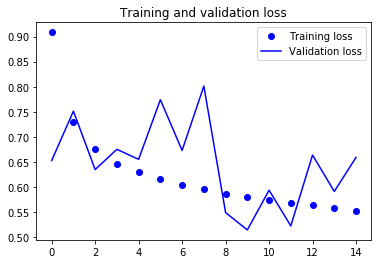

In [14]:
history = pd.read_pickle('binary_segmenter_model_history_dict')
loss = history['loss']
val_loss = history['val_loss']
epochs = range(n_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Mean IoU score on the test set is: 0.41321266503861953
Mean Dice score on the test set is: 0.7886681450313638


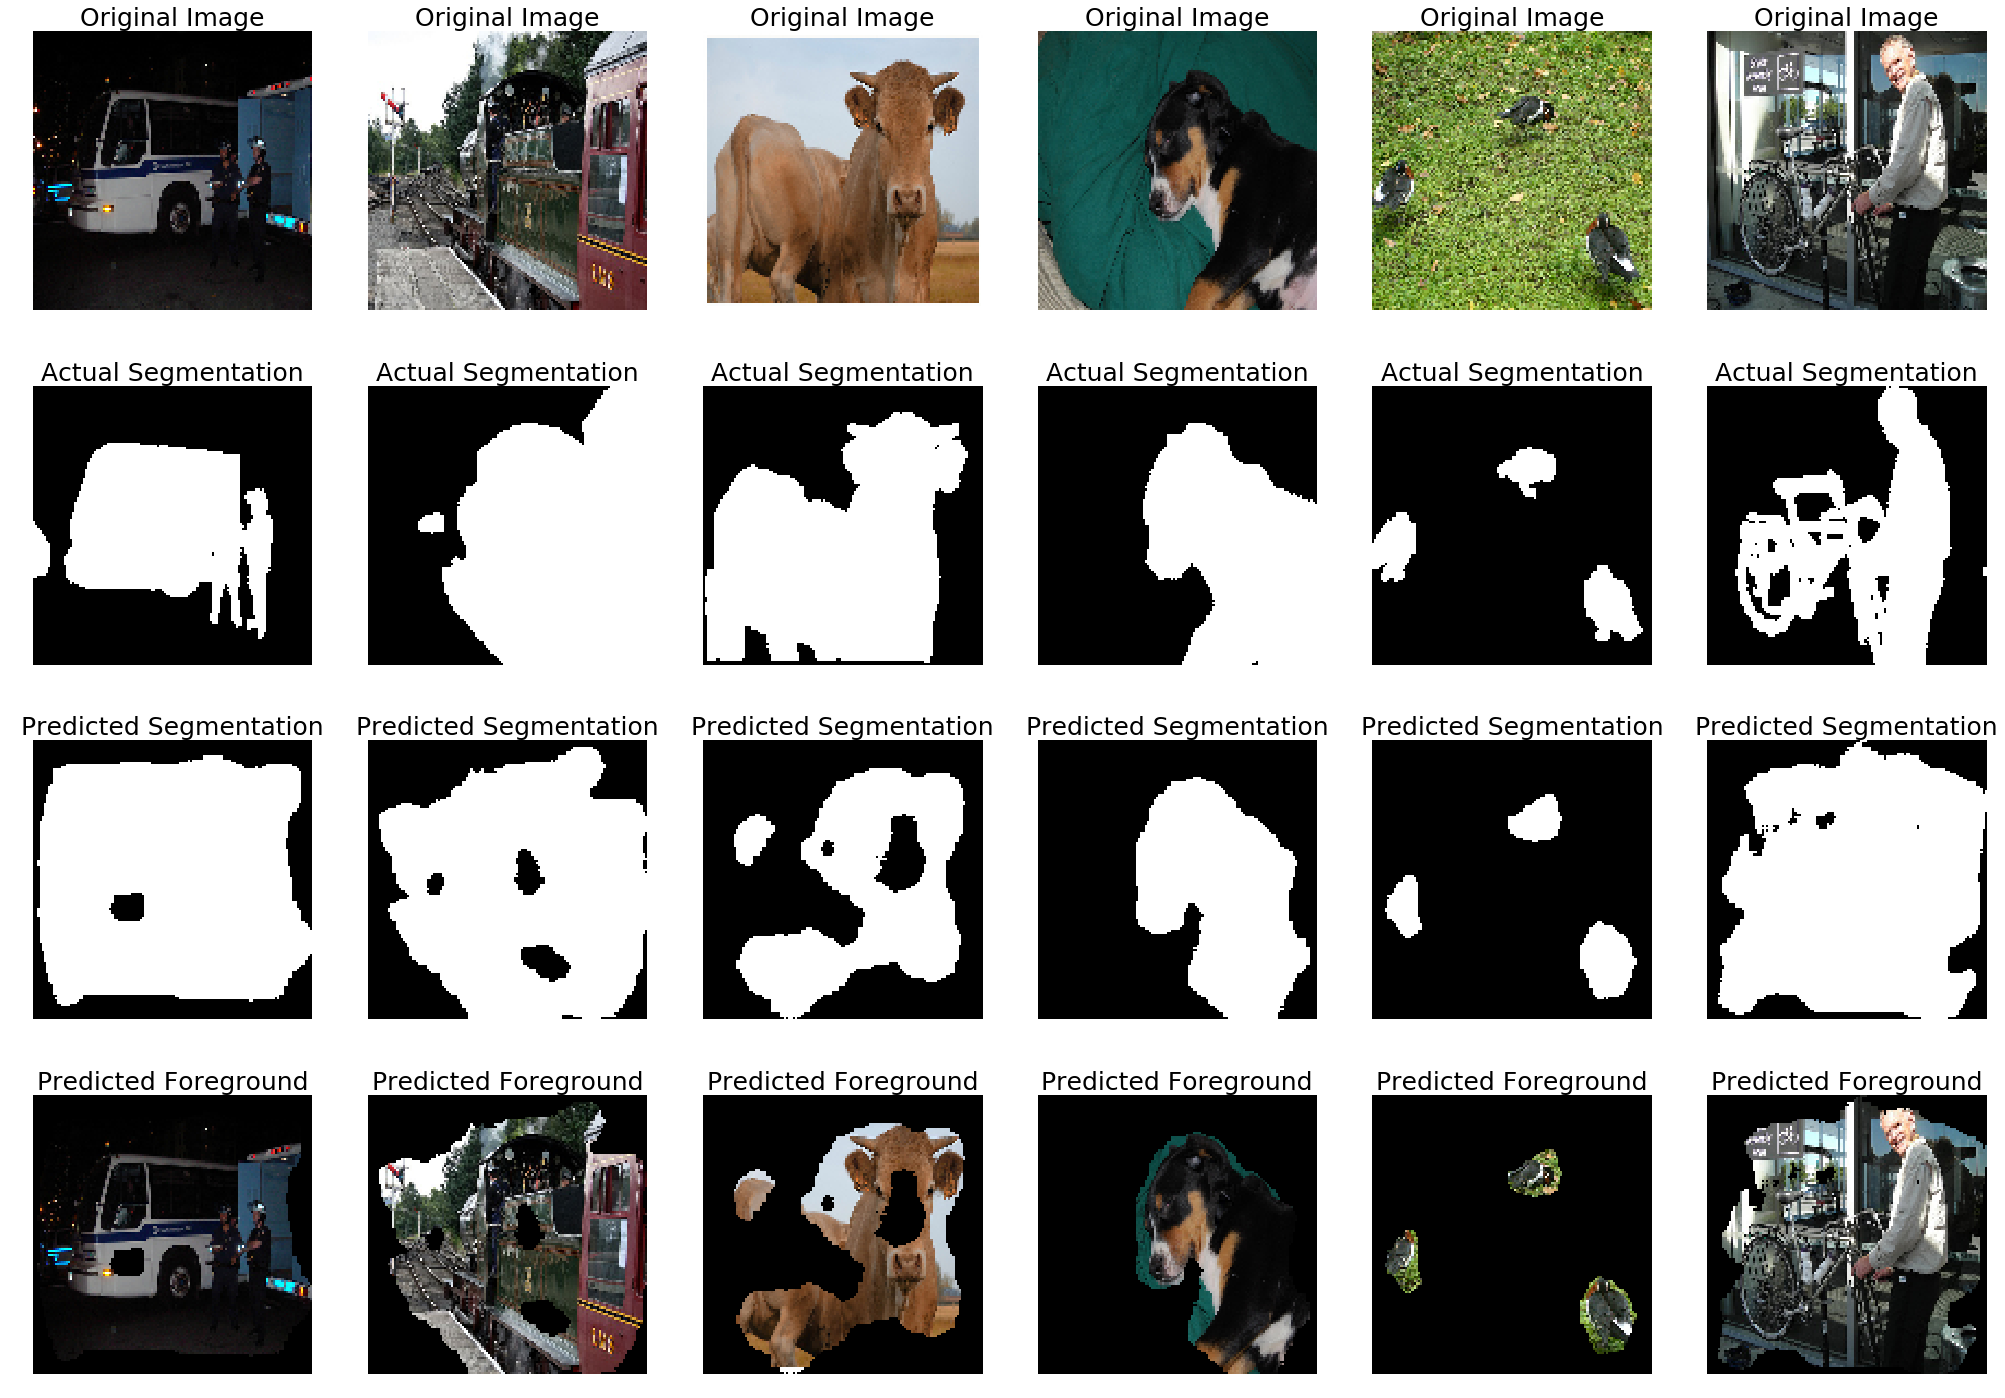

In [15]:
y_test_predict = binary_segmenter_model.predict(x_test)

y_test_predict_list = []
iou_scores_list = []
dice_scores_list = []
for i in range(len(y_test_predict)):
    y_test_pred_i = cv2.cvtColor(y_test_predict[i], cv2.COLOR_BGR2GRAY)
    y_test_pred_i = 255*((y_test_pred_i<=0.5).astype('uint8'))
    y_test_pred_i = cv2.cvtColor(y_test_pred_i, cv2.COLOR_GRAY2BGR)
    y_test_predict_list.append(y_test_pred_i)

    actual = y_test[i]
    predicted = y_test_pred_i
    axes = tuple(range(1, len(y_test_pred_i.shape)-1)) 

    intersection = np.logical_and(actual, predicted)
    union = np.logical_or(actual, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores_list.append(iou_score)


    numerator = 2. * np.sum(predicted * actual, axes)
    denominator = np.sum(np.square(predicted) + np.square(actual), axes)
    dice_score =  1 - np.mean(numerator / (denominator+100)) # average over classes and batch
    dice_scores_list.append(dice_score)
  
y_test_predict = np.array(y_test_predict_list)

print('Mean IoU score on the test set is: ' + str(np.mean(iou_scores_list)))
print('Mean Dice score on the test set is: ' + str(np.mean(dice_scores_list)))

random_indices = [random.randint(0, segmentation_class_val_df.shape[0]) for i in range(6)] 
random_indices = [126, 216, 58, 166, 132, 50]
fig = plt.figure(figsize=(35,25))
ax = fig.subplots(4, 6)
i=0

for index in random_indices:
    actual_image = x_test[index]
    segmented_image = y_test[index]
    predicted_segmented_image = y_test_predict[index]
    
    ax[0,i].imshow(actual_image, cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title('Original Image', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[1,i].imshow(segmented_image)
    ax[1,i].axis('off')
    ax[1,i].set_title('Actual Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[2,i].imshow(predicted_segmented_image, cmap='gray')
    ax[2,i].axis('off')
    ax[2,i].set_title('Predicted Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[3,i].imshow(cv2.subtract(actual_image,255-predicted_segmented_image))
    ax[3,i].axis('off')
    ax[3,i].set_title('Predicted Foreground', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    i = i+1

plt.show()

### Input is the grayscale image of shape (img_rows,img_cols,3) and output is a segmented binary image

In [16]:
x_train_grayscale_1D_list = []
for i in range(len(x_train_grayscale)):
    img_grayscale_1D = cv2.cvtColor(x_train_grayscale[i], cv2.COLOR_BGR2GRAY)
    img_grayscale_1D = img_grayscale_1D.reshape(img_rows,img_cols,1)
    x_train_grayscale_1D_list.append(img_grayscale_1D)
x_train_grayscale_1D = np.array(x_train_grayscale_1D_list)
print(x_train_grayscale_1D.shape)

x_val_grayscale_1D_list = []
for i in range(len(x_val_grayscale)):
    img_grayscale_1D = cv2.cvtColor(x_val_grayscale[i], cv2.COLOR_BGR2GRAY)
    img_grayscale_1D = img_grayscale_1D.reshape(img_rows,img_cols,1)
    x_val_grayscale_1D_list.append(img_grayscale_1D)
x_val_grayscale_1D = np.array(x_val_grayscale_1D_list)
print(x_val_grayscale_1D.shape)

x_test_grayscale_1D_list = []
for i in range(len(x_test_grayscale)):
    img_grayscale_1D = cv2.cvtColor(x_test_grayscale[i], cv2.COLOR_BGR2GRAY)
    img_grayscale_1D = img_grayscale_1D.reshape(img_rows,img_cols,1)
    x_test_grayscale_1D_list.append(img_grayscale_1D)
x_test_grayscale_1D = np.array(x_test_grayscale_1D_list)
print(x_test_grayscale_1D.shape)

(749, 128, 128, 1)
(375, 128, 128, 1)
(375, 128, 128, 1)


In [17]:
y_train_1D_list = []
for i in range(len(y_train)):
    y_train_1D = cv2.cvtColor(y_train[i], cv2.COLOR_BGR2GRAY)
    y_train_1D = y_train_1D.reshape(img_rows,img_cols,1)
    y_train_1D_list.append(y_train_1D)
y_train_1D = np.array(y_train_1D_list)
print(y_train_1D.shape)

y_val_1D_list = []
for i in range(len(y_val)):
    y_val_1D = cv2.cvtColor(y_val[i], cv2.COLOR_BGR2GRAY)
    y_val_1D = y_val_1D.reshape(img_rows,img_cols,1)
    y_val_1D_list.append(y_val_1D)
y_val_1D = np.array(y_val_1D_list)
print(y_val_1D.shape)
  
y_test_1D_list = []
for i in range(len(y_test)):
    y_test_1D = cv2.cvtColor(y_test[i], cv2.COLOR_BGR2GRAY)
    y_test_1D = y_test_1D.reshape(img_rows,img_cols,1)
    y_test_1D_list.append(y_test_1D)
y_test_1D = np.array(y_test_1D_list)
print(y_test_1D.shape)

(749, 128, 128, 1)
(375, 128, 128, 1)
(375, 128, 128, 1)


In [18]:
#CONV Auto-encoder
#Run on Google colab
'''
n_batches = 256

input_img = Input(shape=(img_rows, img_cols, 1))
layer = Conv2D(64, (3, 3), padding='same')(input_img)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2, 2), padding='same')(layer)
layer = Conv2D(32, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2, 2), padding='same')(layer)
layer = Conv2D(16, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
encoded = MaxPooling2D((2, 2), padding='same', name='code')(layer)

layer = Conv2D(16, (3, 3), padding='same')(encoded)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(32, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(64, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(1, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
decoded = Activation('sigmoid')(layer)

binary_segmenter_model_grayscale = Model(input_img, decoded)
print(binary_segmenter_model_grayscale.summary())
binary_segmenter_model_grayscale.compile(optimizer='adam', loss=[dice_coef]) #Try with other optimizers like 'adadelta'
#binary_crossentropy loss function provided a better iou & dice score than cosine_proximity or logcosh
#With default metrics, I got a better performance

history = binary_segmenter_model_grayscale.fit(x_train_grayscale_1D, y_train_1D,epochs=n_epochs,batch_size=n_batches,verbose=1,
                                               validation_data=(x_val_grayscale_1D, y_val_1D),shuffle=True)




# serialize model to JSON
model_json = binary_segmenter_model_grayscale.to_json()
with open("binary_segmenter_model_grayscale.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
binary_segmenter_model_grayscale.save_weights("binary_segmenter_model_grayscale.h5")
with open('binary_segmenter_model_grayscale_history_dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print("Saved model & history to disk")
'''

'\nn_batches = 256\n\ninput_img = Input(shape=(img_rows, img_cols, 1))\nlayer = Conv2D(64, (3, 3), padding=\'same\')(input_img)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = MaxPooling2D((2, 2), padding=\'same\')(layer)\nlayer = Conv2D(32, (3, 3), padding=\'same\')(layer)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = MaxPooling2D((2, 2), padding=\'same\')(layer)\nlayer = Conv2D(16, (3, 3), padding=\'same\')(layer)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nencoded = MaxPooling2D((2, 2), padding=\'same\', name=\'code\')(layer)\n\nlayer = Conv2D(16, (3, 3), padding=\'same\')(encoded)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = UpSampling2D((2, 2))(layer)\nlayer = Conv2D(32, (3, 3), padding=\'same\')(layer)\nlayer = BatchNormalization()(layer)\nlayer = Activation(\'relu\')(layer)\nlayer = UpSampling2D((2, 2))(layer)\nlayer = Conv2D(64, (3, 3), pa

In [19]:
# load json and create model
json_file = open('binary_segmenter_model_grayscale.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
binary_segmenter_model_grayscale = model_from_json(loaded_model_json)
# load weights into new model
binary_segmenter_model_grayscale.load_weights("binary_segmenter_model_grayscale.h5")
print("Loaded model from disk")
binary_segmenter_model_grayscale.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_23 (Batc (None, 64, 64, 32)      

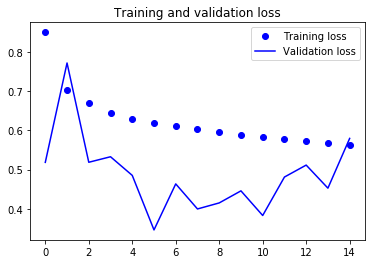

In [20]:
history = pd.read_pickle('binary_segmenter_model_grayscale_history_dict')
loss = history['loss']
val_loss = history['val_loss']
epochs = range(n_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Mean IoU score on the test set is: 0.40565356076552295
Mean Dice score on the test set is: 0.9956603604983659


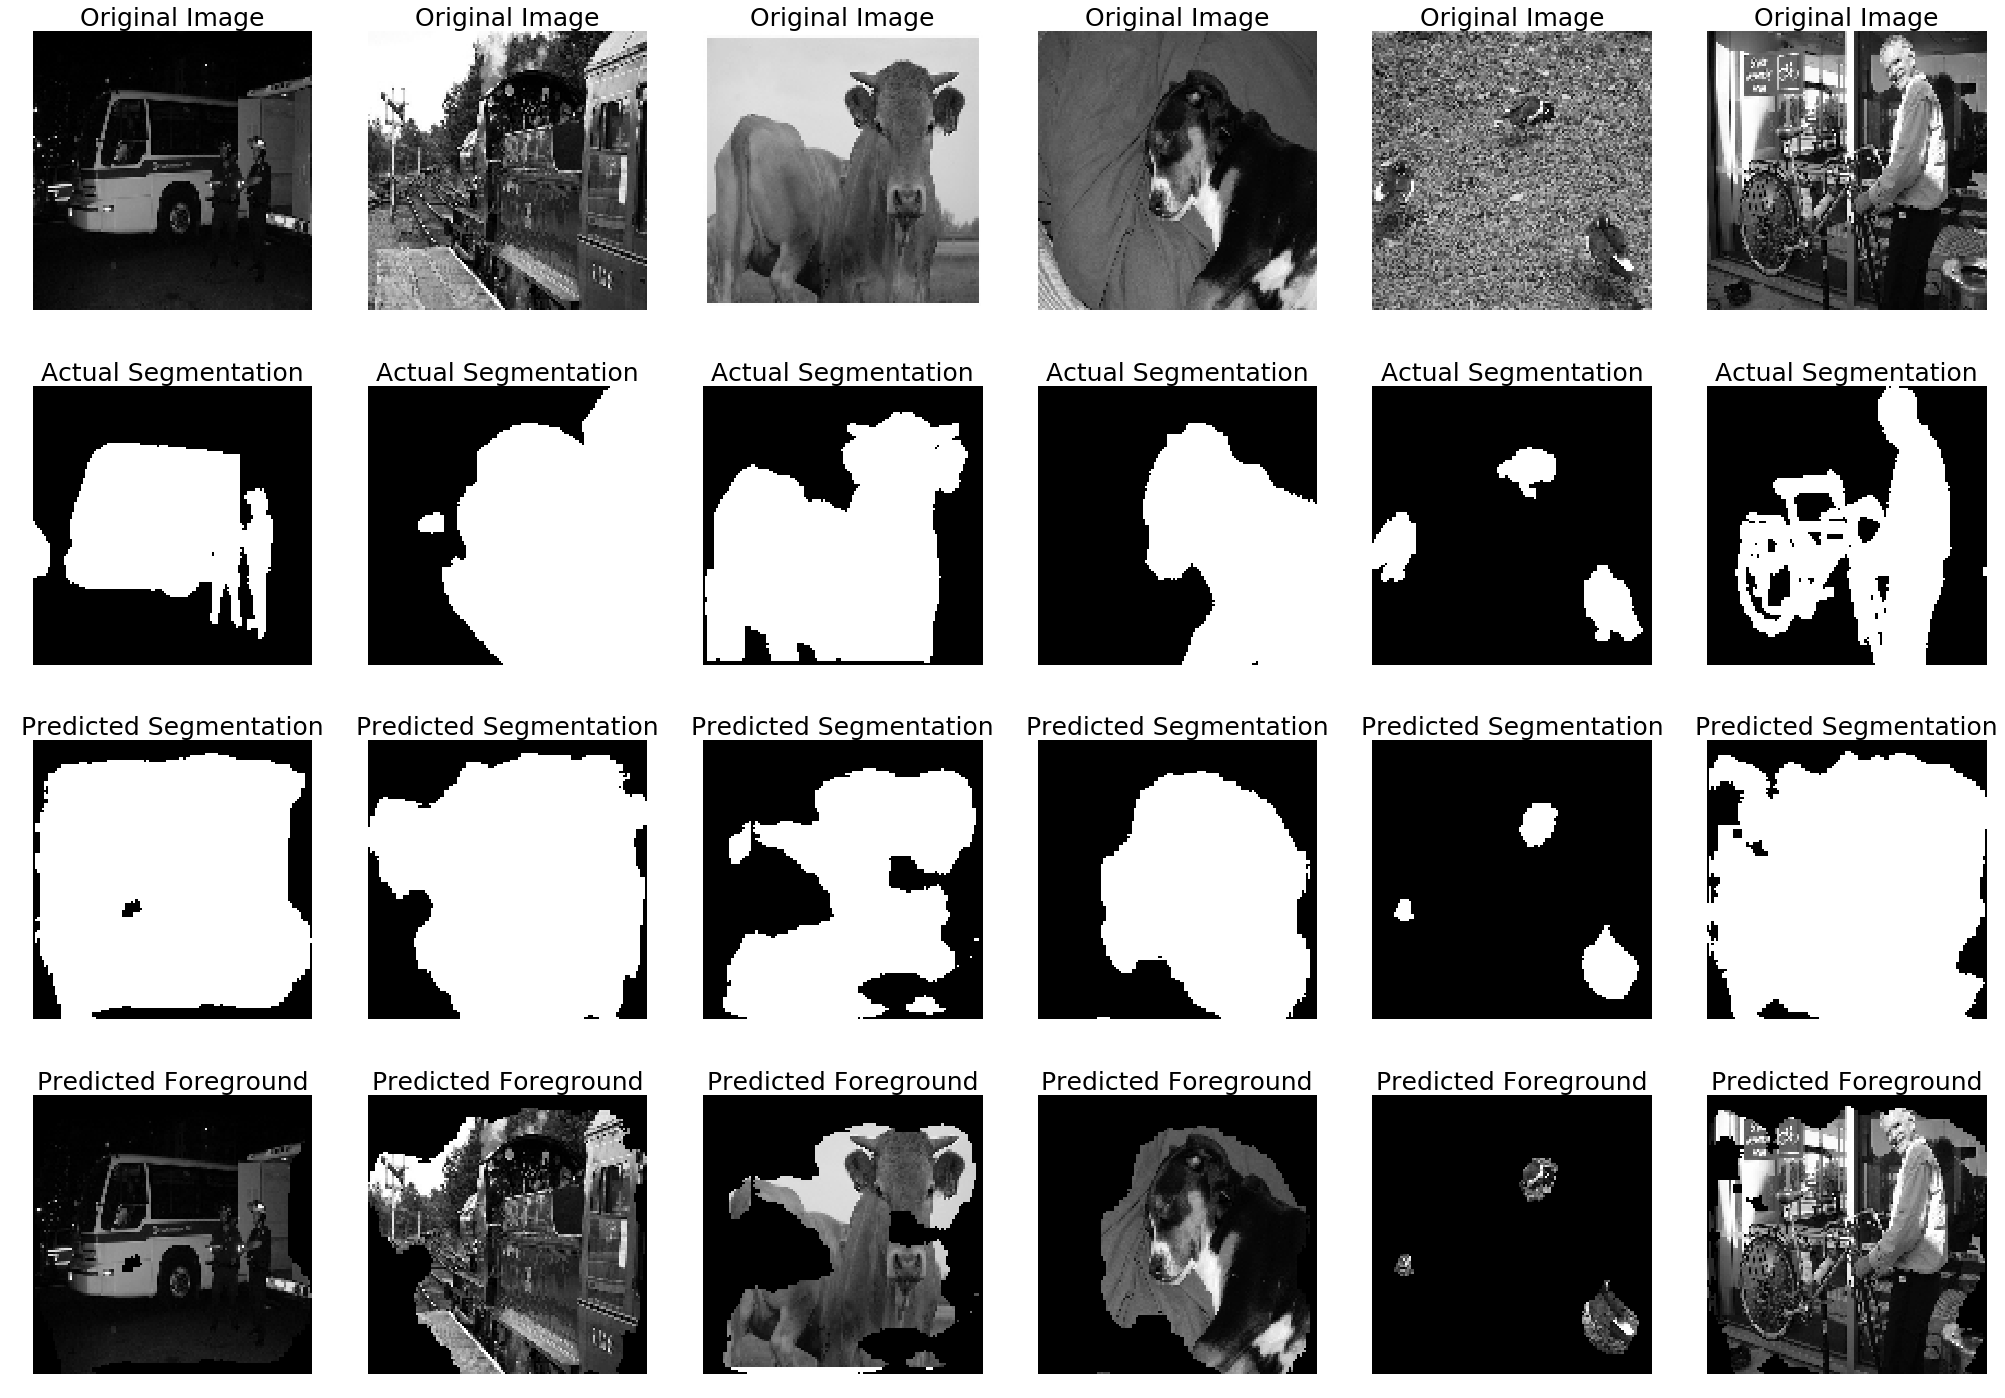

In [21]:
y_test_predict = binary_segmenter_model_grayscale.predict(x_test_grayscale_1D)

y_test_predict_list = []
iou_scores_list = []
dice_scores_list = []
for i in range(len(y_test_predict)):
    y_test_pred_i = 255*((y_test_predict[i]<=0.5).astype('uint8'))
    y_test_pred_i = y_test_pred_i.reshape(img_rows,img_cols)
    y_test_predict_list.append(y_test_pred_i)

    actual = y_test_1D[i].reshape(img_rows,img_rows)
    predicted = y_test_pred_i
    axes = tuple(range(1, len(y_test_pred_i.shape)-1)) 

    intersection = np.logical_and(actual, predicted)
    union = np.logical_or(actual, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores_list.append(iou_score)


    numerator = 2. * np.sum(predicted * actual, axes)
    denominator = np.sum(np.square(predicted) + np.square(actual), axes)
    dice_score =  1 - np.mean(numerator / (denominator+100)) # average over classes and batch
    dice_scores_list.append(dice_score)
  
y_test_predict = np.array(y_test_predict_list)

print('Mean IoU score on the test set is: ' + str(np.mean(iou_scores_list)))
print('Mean Dice score on the test set is: ' + str(np.mean(dice_scores_list)))

fig = plt.figure(figsize=(35,25))
ax = fig.subplots(4, 6)
i=0

for index in random_indices:
    actual_image = x_test_grayscale_1D[index].reshape(img_rows,img_rows)
    segmented_image = y_test[index]
    predicted_segmented_image = y_test_predict[index].reshape(img_rows,img_rows)
    
    ax[0,i].imshow(actual_image, cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title('Original Image', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[1,i].imshow(segmented_image)
    ax[1,i].axis('off')
    ax[1,i].set_title('Actual Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[2,i].imshow(predicted_segmented_image, cmap='gray')
    ax[2,i].axis('off')
    ax[2,i].set_title('Predicted Segmentation', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    ax[3,i].imshow(cv2.subtract(actual_image,255-predicted_segmented_image),cmap='gray')
    ax[3,i].axis('off')
    ax[3,i].set_title('Predicted Foreground', fontdict={'fontsize': 25, 'fontweight': 'medium'})
    i = i+1

plt.show()